In [1]:
from modulefinder import IMPORT_NAME
import sys, platform, os
# import sys, os
sys.path.insert(0,'/global/u1/s/spandey/kmeans_radec/')
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pdb
import healpy as hp
from astropy.io import fits
from kmeans_radec import KMeans, kmeans_sample
import time
import math
from scipy import interpolate
import treecorr
import pickle as pk
import configparser
from pixell import enmap
from pixell import reproject
import ast
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
sys.path.insert(0,'/global/u1/s/spandey/kmeans_radec/')
import kmeans_radec
import h5py as h5
import argparse
from mpi4py import MPI
import gc
import dill



In [2]:
import treecorr
import healpy as hp
import numpy as np
import pickle as pk
from astropy.io import fits



In [3]:
def ang2eq(theta, phi):
    ra = phi * 180. / np.pi
    dec = 90. - theta * 180. / np.pi
    return ra, dec


def eq2ang(ra, dec):
    phi = ra * np.pi / 180.
    theta = (np.pi / 2.) - dec * (np.pi / 180.)
    return theta, phi

def get_zmean(zcent,delz,nz_bin):
    prob_zcent = nz_bin
    zmean = (np.sum(prob_zcent*zcent*delz))/(np.sum(prob_zcent*delz))
    return zmean




In [4]:
do_jk = True
put_weights_datapoints = True
do_randy_sub = True
# njk = 500
# min_r = 0.1
# max_r = 80.
nthreads = 256
bin_slop = 0.0

minrad = 0.1
maxrad = 100.0    
nrad = 20
njk = 100




In [5]:
# from pixell import utils, bunch
# freq = 98
# utils.tsz_spectrum(freq) / utils.dplanck(freq)
minz = 0.4
maxz = 0.5
minM, maxM = 1e14, 5e14
    
ldir_halos = '/global/cfs/cdirs/lsst/www/shivamp/simulated_gy_modeling/create_SZ_maps/data_inp/'
halo_fname = ldir_halos + 'abacus_halo_cat_Mmin_1e11.fits'
df = fits.open(halo_fname)

datapoint_z_all = df[1].data['redshift']
datapoint_ra_all = df[1].data['ra']
datapoint_dec_all = df[1].data['dec']
M200c_all = df[1].data['M200c']
print(np.amin(datapoint_z_all), np.amax(datapoint_z_all))
print(np.amin((M200c_all)), np.amax(np.log10(M200c_all)))
indsel = np.where((datapoint_z_all > minz) & (datapoint_z_all < maxz) &
                  (M200c_all > minM) & (M200c_all < maxM))[0] 

datapoint_z_all = datapoint_z_all[indsel]
datapoint_ra_all = datapoint_ra_all[indsel]
datapoint_dec_all = datapoint_dec_all[indsel]
datapoint_weight_all = np.ones_like(datapoint_z_all)


nrand = 10*len(datapoint_z_all)
rand_ra_all = 90*np.random.rand(nrand)
rand_dec_all = 90*np.random.rand(nrand)
rand_z_all = minz + np.random.rand(nrand) * (maxz - minz)


# Restrict to datapoint selection
selection_z = np.where((datapoint_z_all > minz) & (datapoint_z_all < maxz))[0]
print("num in selection = ", selection_z.shape)
selection_f = selection_z

datapoint_ra = datapoint_ra_all[selection_f]
datapoint_dec = datapoint_dec_all[selection_f]
datapoint_z = datapoint_z_all[selection_f]
datapoint_w = datapoint_weight_all[selection_f]
ndatapoint = len(datapoint_ra)

selection_z_rand = np.where((rand_z_all > minz) & (rand_z_all < maxz))[0]
selection_rand = selection_z_rand

rand_ra, rand_dec = rand_ra_all[selection_rand], rand_dec_all[selection_rand]

nrand = len(rand_ra)

rand_w = np.ones_like(rand_ra)

print(ndatapoint,nrand)


save_dir_jk = '/global/cfs/cdirs/lsst/www/shivamp/simulated_gy_modeling/correlate_SZ_tracer/temp/'
save_filename_jk_obj = 'temp_jk_centers'
if os.path.isfile(save_dir_jk + save_filename_jk_obj):
    datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)           

else:
    datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                    dec_units='degrees', npatch=njk)
    datapoint_cat.write_patch_centers(save_dir_jk + save_filename_jk_obj)
rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, w=rand_w, ra_units='degrees', dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)






0.1 0.79999995


/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


0.0 15.218444
num in selection =  (4010,)
4010 40100


In [6]:
from tqdm import tqdm
jid_all = np.arange(0, 20)
njid = len(jid_all)
xi_all = np.zeros((njid,nrad))
sig_all = np.zeros((njid,nrad))
r_all = np.zeros((njid,nrad))
for ji in tqdm(jid_all):
    ldir = '/global/cfs/cdirs/lsst/www/shivamp/simulated_gy_modeling/create_SZ_maps/output_ymaps/abacus_nLHtot_100_np_3_rs_0/'
    ymap_fname = ldir + 'sim_abacus_nLHtot_100_np_3_rs_0_LHid_' + str(ji) + '.fits'

    rad2deg = 180./np.pi
    # print('opening ymap and mask')
    imapy = enmap.read_map(ymap_fname)
    decs, ras = imapy.posmap()
    ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
    ytruth_cat = treecorr.Catalog(ra=ra_y, dec=dec_y, k=ymap_truth, ra_units='degrees', dec_units='degrees')

    dytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
    randytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

    # print('doing dataxy calculation')
    dytruth.process(datapoint_cat, ytruth_cat)

    # print('doing randomxy calculation')
    randytruth.process(rand_cat, ytruth_cat)
    dytruth.calculateXi(rk=randytruth)

    xi_dy_full = dytruth.xi
    r_dy = np.exp(dytruth.meanlogr)
    cov_dy = dytruth.cov
    sig_dy = np.sqrt(np.diag(cov_dy))
    
    xi_all[ji,:] = xi_dy_full
    r_all[ji,:] = r_dy
    sig_all[ji,:] = sig_dy    

    


100%|██████████| 20/20 [06:32<00:00, 19.64s/it]


In [10]:
# saved = {'r_all':r_all, 'xi_all':xi_all, 'sig_all':sig_all}
# pk.dump(saved, open('temp/temp_xi_saved.pk','wb'))



In [3]:
saved = pk.load(open('temp/temp_xi_saved.pk','rb'))
r_all, xi_all = saved['r_all'], saved['xi_all']


In [4]:
# # !pip install tensorflow_probability
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False




Text(0, 0.5, '$\\xi_{\\rm hy}(\\theta)$')

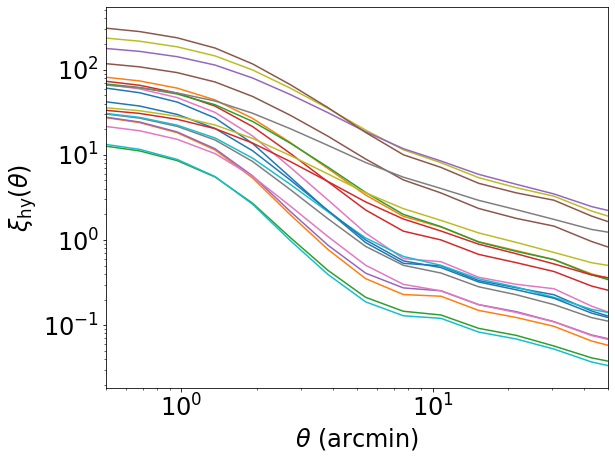

In [11]:
jid_all = np.arange(0, 20)
pl.figure(figsize=(9,7))

for ji in (jid_all):
    pl.plot(r_all[ji,:], -1.*xi_all[ji,:])
pl.xscale('log')
pl.yscale('log')
pl.xlim(0.5,50)
pl.tick_params(axis='both', which='minor', labelsize=24)    
pl.tick_params(axis='both', which='major', labelsize=24)
pl.xlabel(r'$\theta$ (arcmin)', size=24)
pl.ylabel(r'$\xi_{\rm hy}(\theta)$', size=24)




In [23]:
dytruth.xi


array([-34.91485267, -36.18018788, -33.81269444, -33.38714298,
       -32.76328005, -29.27735636, -24.15281108, -17.64641587,
       -11.01824713,  -6.36254952,  -3.98957102,  -2.92308882,
        -2.52560942,  -2.395974  ,  -2.27253946,  -2.22871008,
        -2.18473377,  -2.14631425,  -2.1391842 ,  -2.15126869])

In [24]:
randytruth.process(rand_cat, ytruth_cat)


In [25]:
randytruth.xi


array([-1.82423823, -1.65664499, -1.66029337, -1.6423266 , -1.65429014,
       -1.68216465, -1.7494379 , -1.77913488, -1.79562754, -1.81365444,
       -1.86354006, -1.91981923, -1.94537988, -1.93631931, -1.95945231,
       -1.96369044, -1.98547283, -2.00592935, -2.02318536, -2.05153979])

[ 0.12195617  0.17265746  0.24114485  0.34125977  0.48288161  0.68151432
  0.96222838  1.36066325  1.92000533  2.71341612  3.83294746  5.4134023
  7.64798641 10.80370531 15.26011307 21.55433664 30.4428296  42.99544925
 60.71268185 85.78904478]
[-33.09061444 -34.52354289 -32.15240107 -31.74481638 -31.10898991
 -27.59519171 -22.40337317 -15.86728099  -9.22261959  -4.54889508
  -2.12603096  -1.00326959  -0.58022954  -0.4596547   -0.31308716
  -0.26501965  -0.19926094  -0.1403849   -0.11599884  -0.0997289 ]
[1.55582425 1.17182847 0.80479734 0.61372029 0.762565   0.6847276
 0.43269239 0.38978352 0.37771953 0.34820736 0.27157938 0.17800551
 0.14457704 0.16218402 0.11981951 0.1428738  0.12664048 0.10509003
 0.09727942 0.07007106]


(0.5, 50)

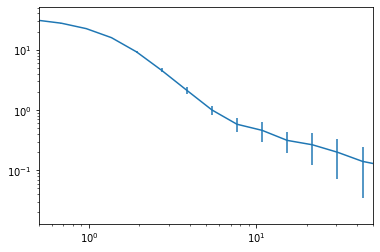

In [29]:
pl.figure()
pl.errorbar(r_dy, -1.*xi_dy_full, np.sqrt(np.diag(cov_dy)))
pl.xscale('log')
pl.yscale('log')
pl.xlim(0.5,50)




(0.5, 50)

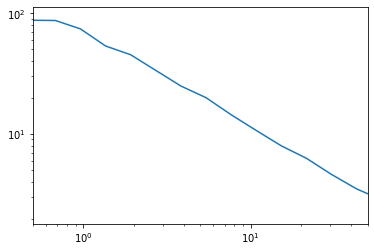

In [83]:
pl.figure()
pl.errorbar(r_dy, xi_dy_full)
pl.xscale('log')
pl.yscale('log')
pl.xlim(0.5,50)


